# 机器学习策略演示

本notebook演示如何使用机器学习方法构建一个简单的交易策略。主要步骤包括：

1. 数据获取与预处理
2. 简单因子/特征构造
3. 目标变量（下期收益）的定义
4. 训练简单的线性回归模型
5. 策略回测
6. 使用Backtrader进行回测

## 0. 导入依赖包

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os
import talib  # 如果报错找不到ta-lib，需先安装并确认本地编译环境
import sys
from dotenv import load_dotenv, find_dotenv
# Find the .env file in the parent directory
dotenv_path = find_dotenv("../../.env")
# Load it explicitly
load_dotenv(dotenv_path)
# Add the parent directory to the sys.path list
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from data_processing import load_data_year, flatten_yf_columns, standardize_columns
from plotting import plot_results
from strategy.buy_and_hold import BuyAndHoldStrategy
from back_test import run_backtest
# 设置显示选项
pd.set_option('display.float_format', lambda x: '%.4f' % x)
# 绘图风格（可选）
plt.style.use('seaborn-v0_8-bright')
# 设置中文显示
plt.rcParams['font.sans-serif'] = ['PingFang HK']
plt.rcParams['axes.unicode_minus'] = False

## 1. 数据获取与预处理

我们获取TSLA过去5年的日线数据。

In [2]:
# 设定时间范围（从现在往前推5年）
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)
print(f"获取数据时间范围：{start_date.strftime('%Y-%m-%d')} 到 {end_date.strftime('%Y-%m-%d')}")
# 下载特斯拉数据
ticker = '002745.SZ'
data = yf.download(ticker, start=start_date, end=end_date)

获取数据时间范围：2020-03-12 到 2025-03-11
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


## 1.2 数据预处理

In [3]:
data = flatten_yf_columns(data)
data = standardize_columns(data)

In [4]:
print(data.info())              # 看看总共有多少行、列，各字段数据类型
print(data.head(10))           # 查看前10行，确认最早日期
print(data.tail(10))           # 查看后10行，确认最晚日期
print(data.index.min())  # DataFrame中最早的日期
print(data.index.max())  # DataFrame中最晚的日期


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1211 entries, 2020-03-12 to 2025-03-11
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   1211 non-null   float64
 1   high    1211 non-null   float64
 2   low     1211 non-null   float64
 3   open    1211 non-null   float64
 4   volume  1211 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 56.8 KB
None
             close    high     low    open    volume
Date                                                
2020-03-12 10.4847 10.7047 10.3702 10.5815  13211784
2020-03-13 10.3878 10.4935  9.7892  9.8772  14584960
2020-03-16  9.8332 10.5287  9.7188 10.4759  14632418
2020-03-17  9.9037 10.0709  9.5955  9.9389  12288573
2020-03-18  9.7012 10.1678  9.6660 10.0181  13335447
2020-03-19  9.8420  9.9301  9.5515  9.6924  11539813
2020-03-20  9.9037 10.0445  9.7276  9.9741   7842689
2020-03-23  9.2522  9.6836  9.2170  9.6836  10991959
2020-03-24  9.3843  9.5251  9.1

## 2. 加入更多技术指标

构建两个简单的因子：
1. 动量因子：过去5日涨跌幅
2. 成交量比值：最近5日均量vs最近10日均量
3. 先举几个常用指标的例子：RSI, MACD, 布林带。

In [5]:
# 复制数据
df = data.copy()
# 动量因子: 过去5日涨跌幅
df['momentum_5'] = df['close'] / df['close'].shift(5) - 1
# 成交量因子: (最近5日平均成交量) / (最近10日平均成交量) - 1
df['vol_ratio'] = (df['volume'].rolling(5).mean()) / (df['volume'].rolling(10).mean()) - 1
# 计算RSI (默认周期14)
df['RSI_14'] = talib.RSI(df['close'], timeperiod=14)
# # 计算MACD相关数值: MACD, MACD信号线, MACD直方图
# macd, macd_signal, macd_hist = talib.MACD(
#     df['close'],
#     fastperiod=12,
#     slowperiod=26,
#     signalperiod=9
# )
# df['MACD'] = macd
# df['MACD_signal'] = macd_signal
# df['MACD_hist'] = macd_hist
# 布林带
upper, middle, lower = talib.BBANDS(
    df['close'],
    timeperiod=20,
    nbdevup=2,
    nbdevdn=2,
    matype=0
)
df['BB_upper'] = upper
df['BB_middle'] = middle
df['BB_lower'] = lower
# 也可以增加其他指标，比如ATR, CCI等，根据需要添加
df.dropna(inplace=True)  # 丢掉因子无法计算的前几行
# factors = ['momentum_5', 'vol_ratio' ,'RSI_14','MACD','MACD_signal','BB_upper','BB_lower']
factors = ['momentum_5', 'vol_ratio' ,'RSI_14','BB_upper','BB_lower']
# 看看加上技术指标后的DataFrame
print(df[['close'] + factors].tail(5))


            close  momentum_5  vol_ratio  RSI_14  BB_upper  BB_lower
Date                                                                
2025-03-05 9.5200      0.0182    -0.0132 66.1087    9.6090    7.6600
2025-03-06 9.7500      0.0417    -0.0255 68.8765    9.7815    7.6335
2025-03-07 9.5300      0.0891    -0.0968 63.5318    9.8844    7.6476
2025-03-10 9.6700      0.0488    -0.1746 65.3732    9.9977    7.6703
2025-03-11 9.3400     -0.0064    -0.1987 57.9459   10.0435    7.7265


## 3. 目标变量的定义

定义下期1日收益率作为目标变量。

添加目标变量后的数据预览：
             close  momentum_5  vol_ratio  RSI_14  BB_upper  BB_lower
Date                                                                 
2020-04-09 11.0041      0.0785     0.0847 55.2221   11.3106    9.2045
2020-04-10 10.8104      0.0372     0.1971 52.5523   11.3502    9.1974
2020-04-13 10.4230     -0.0366     0.1009 47.5962   11.3528    9.1983
2020-04-14 10.6519     -0.0218     0.0276 50.5631   11.3856    9.2474
2020-04-15 10.4054     -0.0830    -0.1377 47.4476   11.3942    9.2890
2020-04-16 10.2206     -0.0712    -0.2386 45.1982   11.3806    9.3546
2020-04-17 10.2118     -0.0554    -0.3519 45.0886   11.3732    9.3990
2020-04-20 10.2646     -0.0152    -0.3439 45.9358   11.3682    9.4400
2020-04-21 10.0269     -0.0587    -0.2945 42.7401   11.2714    9.6143
2020-04-22 10.0709     -0.0321    -0.2457 43.5236   11.1739    9.7805


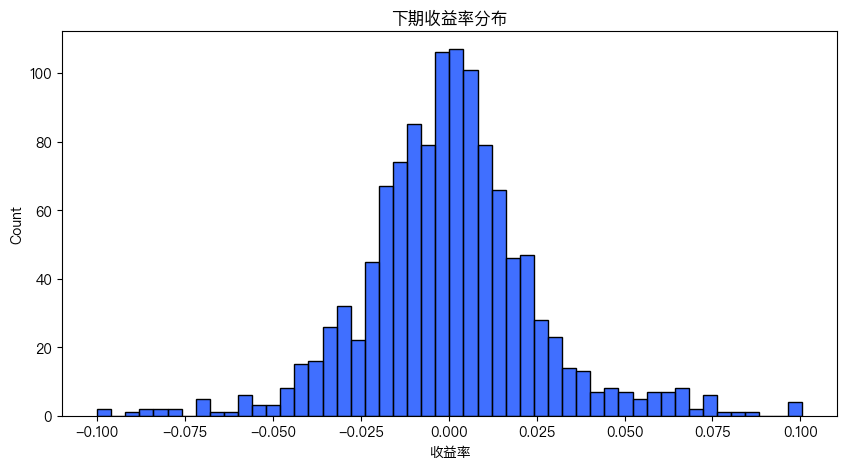

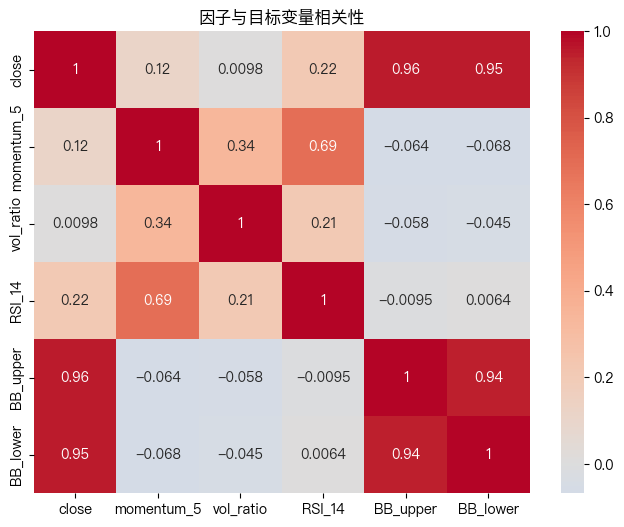

In [6]:
# 计算下期收益率
df['future_ret_1d'] = df['close'].pct_change().shift(-1)
# 去掉NaN值
df.dropna(inplace=True)
print("添加目标变量后的数据预览：")
print(df[['close']+factors].head(10))
# 绘制目标变量分布
plt.figure(figsize=(10, 5))
sns.histplot(df['future_ret_1d'], bins=50)
plt.title('下期收益率分布')
plt.xlabel('收益率')
plt.show()
# 计算因子与目标变量的相关性
corr = df[['close']+factors].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('因子与目标变量相关性')
plt.show()

## 4. 划分训练集与测试集

按照时间顺序，使用前80%的数据作为训练集，后20%作为测试集。

训练集范围: 2020-04-09 00:00:00 → 2024-03-12 00:00:00
测试集范围: 2024-03-13 00:00:00 → 2025-03-10 00:00:00

训练集样本数: 952
测试集样本数: 239


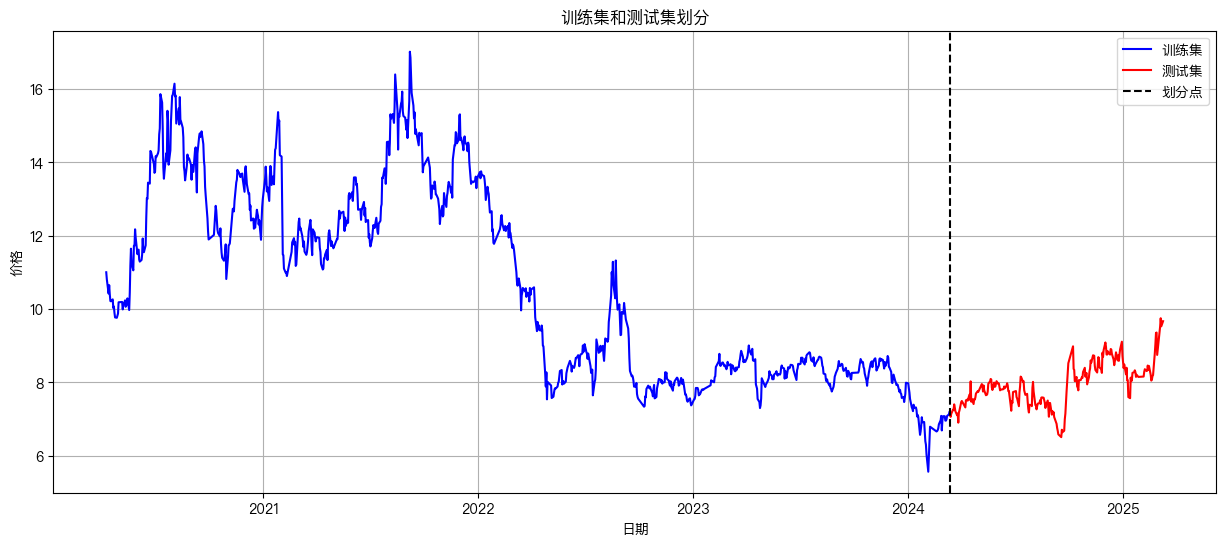

In [18]:
# 计算分割点
split_idx = int(len(df) * 0.8)
split_date = df.index[split_idx]
train_data = df.iloc[:split_idx].copy()
test_data = df.iloc[split_idx:].copy()
print("训练集范围:", train_data.index.min(), "→", train_data.index.max())
print("测试集范围:", test_data.index.min(), "→", test_data.index.max())
print("\n训练集样本数:", len(train_data))
print("测试集样本数:", len(test_data))
# 可视化训练集和测试集的划分
plt.figure(figsize=(15, 6))
plt.plot(train_data.index, train_data['close'], label='训练集', color='blue')
plt.plot(test_data.index, test_data['close'], label='测试集', color='red')
plt.axvline(split_date, color='black', linestyle='--', label='划分点')
plt.title('训练集和测试集划分')
plt.xlabel('日期')
plt.ylabel('价格')
plt.legend()
plt.grid(True)
plt.show()


训练集范围: 2020-04-09 00:00:00 → 2024-03-12 00:00:00
测试集范围: 2024-03-13 00:00:00 → 2025-03-10 00:00:00

训练集样本数: 952
测试集样本数: 239


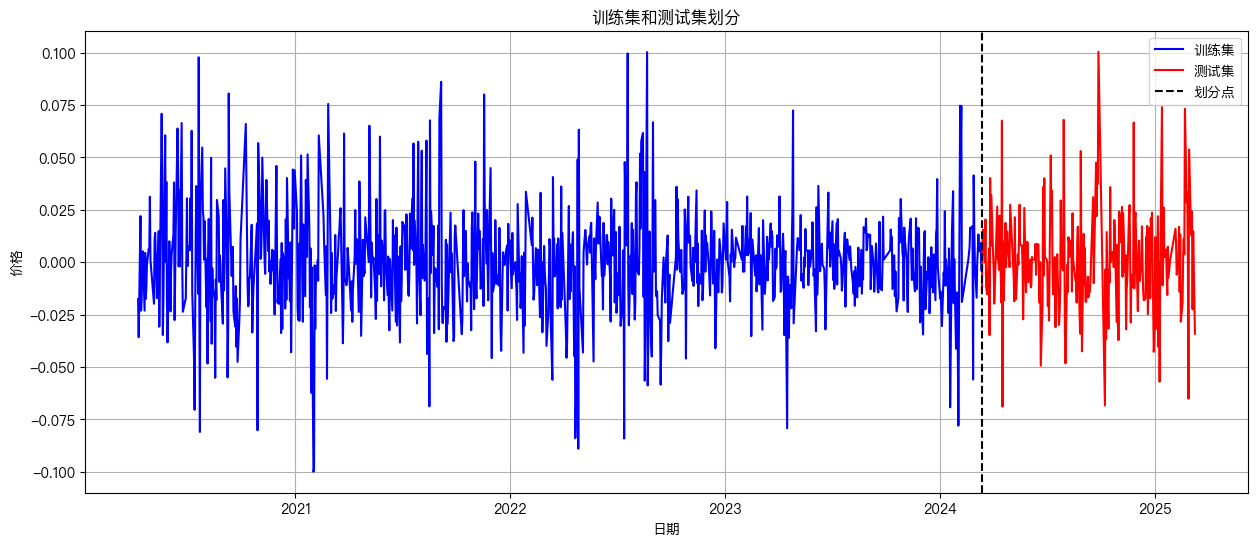

In [19]:
# 计算分割点
split_idx = int(len(df) * 0.8)
split_date = df.index[split_idx]
train_data = df.iloc[:split_idx].copy()
test_data = df.iloc[split_idx:].copy()
print("训练集范围:", train_data.index.min(), "→", train_data.index.max())
print("测试集范围:", test_data.index.min(), "→", test_data.index.max())
print("\n训练集样本数:", len(train_data))
print("测试集样本数:", len(test_data))
# 可视化训练集和测试集的划分
plt.figure(figsize=(15, 6))
plt.plot(train_data.index, train_data['future_ret_1d'], label='训练集', color='blue')
plt.plot(test_data.index, test_data['future_ret_1d'], label='测试集', color='red')
plt.axvline(split_date, color='black', linestyle='--', label='划分点')
plt.title('训练集和测试集划分')
plt.xlabel('日期')
plt.ylabel('价格')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
print(f"测试集目标变量的均值={np.mean(train_data['future_ret_1d'])}")
print(f"测试集目标变量的方差={np.std(train_data['future_ret_1d'])}")
mean_train = np.mean(train_data['future_ret_1d'])
std_train = np.std(train_data['future_ret_1d'])

测试集目标变量的均值=-0.00014120478647154433
测试集目标变量的方差=0.02491642986648611


## 5. 训练线性回归模型

In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
# 从训练集中取X和y
features = factors
X_train = train_data[features].values
y_train = train_data['future_ret_1d'].values
# 同理，测试集
X_test = test_data[features].values
y_test = test_data['future_ret_1d'].values
# 建模
model = LinearRegression()
model.fit(X_train, y_train)
# 预测
y_pred_train = model.predict(X_train)
y_pred_test  = model.predict(X_test)
# 评估 - 用 MSE 举例
train_mse = mean_squared_error(y_train, y_pred_train)
test_mse  = mean_squared_error(y_test, y_pred_test)
print("Train MSE:", train_mse)
print("Test MSE: ", test_mse)
# 查看训练后的回归系数
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
print("训练集 R2:", train_r2)
print("测试集 R2:", test_r2)


NameError: name 'X_train' is not defined

## 6. 使用Backtrader进行回测

In [34]:
import backtrader as bt
# 自定义成交量指标，把成交量数据单独显示在子图中
class MyVolumeIndicator(bt.Indicator):
    """
    简单示例，把data的volume包装成一个单独的子图指标。
    """
    lines = ('vol',)
    plotinfo = dict(subplot=True, plotname='Volume')  # 让它单独开子图
    def __init__(self):
        self.lines.vol = self.data.volume
class MLFactorStrategy(bt.Strategy):
    params = (
        ('model', None),            # 预先训练好的机器学习模型
        ('target_percent', 0.98),   # 目标仓位百分比
        ('mean', 0),
        ('std', 0)
    )
    def __init__(self):
        self.model = self.p.model
        # 关闭主图中Data自带的Volume绘制
        self.data.plotinfo.plotvolume = False
        # 自定义成交量指标以及其SMA指标
        self.myvol = MyVolumeIndicator(self.data)
        self.vol_5 = bt.indicators.SMA(self.myvol.vol, period=5)
        self.vol_5.plotinfo.subplot = True
        self.vol_10 = bt.indicators.SMA(self.myvol.vol, period=10)
        self.vol_10.plotinfo.subplot = True
        # 添加其它因子指标
        # 价格动量指标：计算5日价格百分比变化
        self.momentum_5 = bt.indicators.PercentChange(self.data.close, period=5)
        # RSI指标，14日周期
        self.rsi_14 = bt.indicators.RSI(self.data.close, period=14)
        # 布林带指标，默认20日均线和2倍标准差，返回上轨、均线和下轨
        self.bb = bt.indicators.BollingerBands(self.data.close)
        self.last_trade_type = None  # 记录上一次交易类型（buy/sell）
        self.value_history_dates = []
        self.value_history_values = []
    def next(self):
        # 计算各个因子的当前值
        momentum = self.momentum_5[0]
        vol_ratio = (self.vol_5[0] / self.vol_10[0] - 1) if self.vol_10[0] != 0 else 0
        rsi = self.rsi_14[0]
        bb_upper = self.bb.top[0]  # 布林带上轨
        bb_lower = self.bb.bot[0]  # 布林带下轨
        # 构建特征向量：注意顺序需要与模型训练时一致
        X = [[momentum, vol_ratio, rsi, bb_upper, bb_lower]]
        pred_ret = self.model.predict(X)[0]
        # 获取当前持仓状态
        current_position = self.getposition().size
        if pred_ret > self.p.mean and current_position == 0:
            # 只有当当前没有仓位时，才执行买入
            self.order_target_percent(target=self.p.target_percent)
            self.last_trade_type = "BUY"
            print(f"{self.datas[0].datetime.date(0)} => BUY signal, pred_ret={pred_ret:.6f}")
        elif pred_ret <= 0 and current_position > 0:
            # 只有当当前有仓位时，才执行卖出
            self.order_target_percent(target=0.0)
            self.last_trade_type = "SELL"
            print(f"{self.datas[0].datetime.date(0)} => SELL signal, pred_ret={pred_ret:.6f}")
        # 只在交易执行时打印仓位信息
        if self.last_trade_type:
            print(f"Current position size: {self.getposition().size}, Value: {self.broker.getvalue()}")
        dt = self.data.datetime.date(0)
        self.value_history_dates.append(dt)
        self.value_history_values.append(self.broker.getvalue())


In [36]:
# 若想看最优参数的详细回测日志，可再手动调用:
ml_result, ml_cerebro = run_backtest(
    ticker=ticker,
    df=df.iloc[split_idx:].copy(),
    start_date=start_date,
    end_date=end_date,
    strategy=MLFactorStrategy,
    initial_cash=100000,
    strategy_params={'model': model, 'target_percent':0.98, 'mean': mean_train, 'std': std_train},
    print_log=True,  # 这次打开日志
)


初始资金: 100000.00
2024-04-11 => BUY signal, pred_ret=0.001427
Current position size: 0, Value: 100000.0
Current position size: 13014, Value: 99010.5821576385
Current position size: 13014, Value: 101172.33199646755
Current position size: 13014, Value: 99250.77451565547
Current position size: 13014, Value: 105856.1140055923
Current position size: 13014, Value: 98650.29982617183
Current position size: 13014, Value: 99611.07546379848
Current position size: 13014, Value: 97809.60795643611
Current position size: 13014, Value: 99611.07546379848
Current position size: 13014, Value: 99370.87069466396
2024-04-25 => SELL signal, pred_ret=-0.000218
Current position size: 13014, Value: 100091.46017983241
Current position size: 0, Value: 99512.83072015885
Current position size: 0, Value: 99512.83072015885
Current position size: 0, Value: 99512.83072015885
Current position size: 0, Value: 99512.83072015885
2024-05-07 => BUY signal, pred_ret=0.000235
Current position size: 0, Value: 99512.83072015885
Cu

In [12]:
# ===== 猴子补丁：为 numpy 添加 bool8 和 object 属性 =====
import numpy as np
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_  # 使用 numpy 自带的 bool_ 类型
if not hasattr(np, 'object'):
    np.object = object  # 兼容 backtrader_plotting 的引用

/var/folders/lb/hgfyjd8d6jdgjkfcksmwvbd80000gq/T/ipykernel_18404/1425693070.py:5: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, 'object'):


In [13]:
plot_results(ml_cerebro)

Loading BokehJS ...

# 7. 对比 Buy&Hold 策略

In [14]:
# 若想看最优参数的详细回测日志，可再手动调用:
bh_result, bh_cerebro = run_backtest(
    ticker=ticker,
    df=test_data,
    start_date=start_date,
    end_date=end_date,
    strategy=BuyAndHoldStrategy,
    initial_cash=100000,
    print_log=True,  # 这次打开日志
    timeframe=bt.TimeFrame.Days,
    compression=1
)

初始资金: 100000.00
2024-03-13 00:00:00 [买入] 执行买入并持有策略: 价格=7.16, 数量=13266
2024-03-14 00:00:00 [成交] 买单执行: 价格=7.17, 数量=13266
2025-03-10 00:00:00 [回测结束] Buy & Hold 策略最终市值: 133064.78
2025-03-10 00:00:00 [回测结束] 总收益率: 33.06%
回测结束资金: 133064.78
=== 回测分析报告 ===
夏普比率: 0.9734
最大回撤比例: 19.38%
最大回撤金额(自定义): 21900.74
累计收益率: 28.57%
年化收益率: 35.15%
=== 交易详情 ===
总交易笔数: 1
胜率: 0 / 1


# 比较策略和Buy&Hold

In [15]:
results = ml_cerebro.run()  # cerebro.run() 返回一个列表，每个元素是一个策略实例
ml_strategy_instance = results[0]  # 如果你只有一个策略，就取第一个
results = bh_cerebro.run()
bh_strategy_instance = results[0]

2024-04-11 => BUY signal, pred_ret=0.001427
Current position size: 0, Value: 100000.0
Current position size: 13014, Value: 99010.5821576385
Current position size: 13014, Value: 101172.33199646755
Current position size: 13014, Value: 99250.77451565547
Current position size: 13014, Value: 105856.1140055923
Current position size: 13014, Value: 98650.29982617183
Current position size: 13014, Value: 99611.07546379848
Current position size: 13014, Value: 97809.60795643611
Current position size: 13014, Value: 99611.07546379848
Current position size: 13014, Value: 99370.87069466396
2024-04-25 => SELL signal, pred_ret=-0.000218
Current position size: 13014, Value: 100091.46017983241
Current position size: 0, Value: 99512.83072015885
Current position size: 0, Value: 99512.83072015885
Current position size: 0, Value: 99512.83072015885
Current position size: 0, Value: 99512.83072015885
2024-05-07 => BUY signal, pred_ret=0.000235
Current position size: 0, Value: 99512.83072015885
Current position s

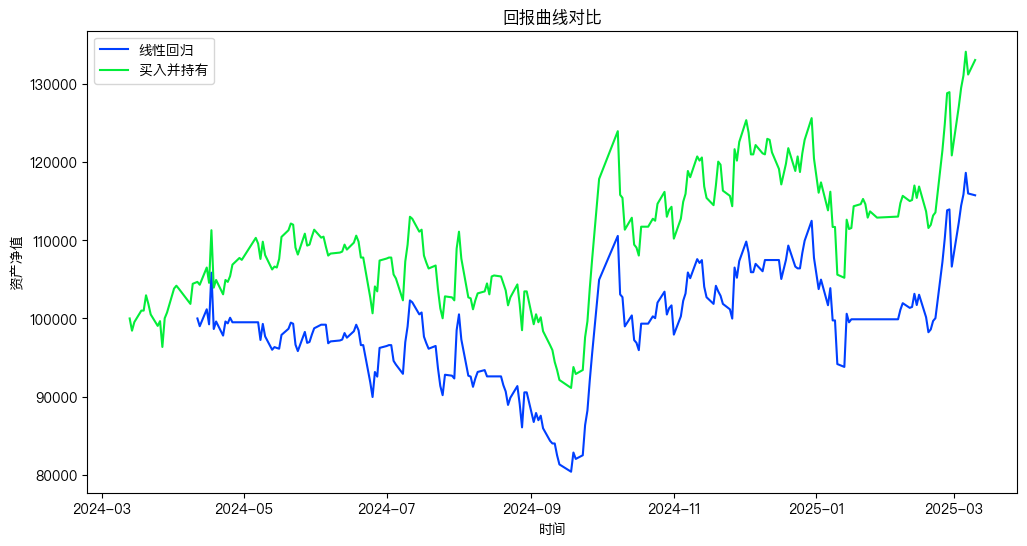

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(ml_strategy_instance.value_history_dates, ml_strategy_instance.value_history_values, label='线性回归')
plt.plot(bh_strategy_instance.value_history_dates, bh_strategy_instance.value_history_values, label='买入并持有')
plt.xlabel('时间')
plt.ylabel('资产净值')
plt.title('回报曲线对比')
plt.legend()
plt.show()